# Outline
1. Comment-tree morphology (w.r.t. sentiment later)
    - depth profile
    - branching factor
    - shape imbalance
    - DO not ahole answer more than ntahole 
2. User-interaction network
    - Measures: assortativity, clustering coefficient, betweenness centrality
    - community detection: YTA-leaning vs NTA-leaning (Louvain)

# Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
from networkx.algorithms import assortativity
import statistics
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.collections as mcoll
import matplotlib.cm as cm
import collections
from tqdm import tqdm
import os
import json
import math
import praw
import time
from praw.models import MoreComments
from prawcore.exceptions import TooManyRequests

In [2]:
def plot_graph(G, title):
    plt.figure(figsize=(20, 20))
    nx.draw_spring(
        G,
        node_size=40,
        with_labels=False,
        edge_color='gray'
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
with open("../redditCredentials.json", "r") as f:
    credentials = json.load(f)

reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='AITA-analysis',
                     username=credentials['USERNAME'],
                     check_for_async=False)

# Reply Graphs Analysis

## Building Reply Graphs

### Defining Functions and preparing Submission IDS

In [5]:
df = pd.read_csv('top450-aita-balanced.csv')

subset_20_A_Hole = (
    df.loc[df["link_flair_text"] == "Asshole"]
    .sample(n=20, random_state=42) 
)

subset_20_NTA_Hole = (
    df.loc[df["link_flair_text"] == "Not the A-hole"]
    .sample(n=20, random_state=42) 
)

In [6]:
def build_author_reply_graph(submission_id: str, reddit: praw.Reddit):

    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    stack = collections.deque(
        (subm.author, top)
        for top in subm.comments
    )

    while stack:
        parent_author, comment = stack.pop()

        if parent_author is None or comment.author is None:
            pass
        else:
            src = str(parent_author)
            tgt = str(comment.author)
            edges.append((src, tgt))
        for child in comment.replies:
            stack.append((comment.author, child))

    return edges

def build_authorID_reply_graph(submission_id: str, reddit: praw.Reddit):

    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    stack = collections.deque(
        (subm.author, top)
        for top in subm.comments
    )

    while stack:
        parent_author, comment = stack.pop()

        if parent_author is None or comment.author is None:
            pass
        else:
            src = str(parent_author)
            tgt = str(comment.author)
            edges.append((src, tgt))
        for child in comment.replies:
            stack.append((comment.author, child))

    return edges

import collections

def build_combined_reply_graph(submission_id: str, reddit: praw.Reddit):
    """
    Traverse all comments in a submission and collect edges that contain:
      - parent comment ID (or submission ID for top‐level)
      - child comment ID
      - parent author username (or None if deleted)
      - child author username (or None if deleted)
    Returns a list of tuples:
      (parent_id, child_id, parent_author, child_author)
    """
    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    # Initialize stack: for each top‐level comment, parent_id = submission ID, parent_author = submission author
    stack = collections.deque(
        (subm.id, subm.author, top) 
        for top in subm.comments
    )

    while stack:
        parent_id, parent_author, comment = stack.pop()

        child_id = comment.id
        child_author = comment.author

        # Convert authors to strings (or keep None if deleted)
        parent_author_str = str(parent_author) if parent_author is not None else None
        child_author_str = str(child_author) if child_author is not None else None

        # Record the edge (IDs + authors). Even if an author is None, the IDs may still be useful later.
        edges.append((parent_id, child_id, parent_author_str, child_author_str))

        # Push each reply onto the stack, setting parent to this comment
        for reply in comment.replies:
            stack.append((comment.id, comment.author, reply))

    return edges


### Gathering Data

In [98]:
### A-Hole

for i, submission_id in enumerate(tqdm(subset_20_A_Hole["id"], desc="Building reply graphs")):

    output_path = f"replyGraphs/reply_graph-submission_{submission_id}_AHole.csv"
    if os.path.exists(output_path):
        continue
    
    retries = 0

    while True:
        try:
            edges = build_combined_reply_graph(submission_id, reddit)
            break
        except TooManyRequests:
            retries += 1
            backoff = min(60 * retries, 300)
            print(f"429 on {submission_id}: sleeping {backoff} seconds (retry #{retries})")
            time.sleep(backoff)
        except Exception as e:
            print(f"Error on {submission_id}: {e}. Skipping this submission.")
            edges = []
            break

    if edges:
        df = pd.DataFrame(
            edges,
            columns=['parent_id', 'child_id', 'parent_author', 'child_author']
        )
        df.to_csv(f"replyGraphs/reply_graph-submission_{submission_id}_AHole.csv", index=False)

    time.sleep(5)

Building reply graphs:   0%|          | 0/20 [00:00<?, ?it/s]

Building reply graphs:  70%|███████   | 14/20 [12:16<08:06, 81.15s/it]

429 on cdypge: sleeping 60 seconds (retry #1)


Building reply graphs: 100%|██████████| 20/20 [38:12<00:00, 114.60s/it]


In [7]:
### Not The A-Hole

for i, submission_id in enumerate(tqdm(subset_20_NTA_Hole["id"], desc="Building reply graphs")):

    output_path = f"replyGraphs/reply_graph-submission_{submission_id}_NTAHole.csv"
    if os.path.exists(output_path):
        continue
    
    retries = 0

    while True:
        try:
            edges = build_combined_reply_graph(submission_id, reddit)
            break
        except TooManyRequests:
            retries += 1
            backoff = min(60 * retries, 300)
            print(f"429 on {submission_id}: sleeping {backoff} seconds (retry #{retries})")
            time.sleep(backoff)
        except Exception as e:
            print(f"Error on {submission_id}: {e}. Skipping this submission.")
            edges = []
            break

    if edges:
        df = pd.DataFrame(
            edges,
            columns=['parent_id', 'child_id', 'parent_author', 'child_author']
        )
        df.to_csv(f"replyGraphs/reply_graph-submission_{submission_id}_NTAHole.csv", index=False)

    time.sleep(5)

Building reply graphs:   0%|          | 0/20 [00:00<?, ?it/s]

Building reply graphs: 100%|██████████| 20/20 [03:55<00:00, 11.79s/it]


In [8]:
### Reading from CSV

folder_path = "replyGraphs"
rel_AHole = dict()
rel_NTAHole = dict()

for filename in os.listdir(folder_path):
    if filename.endswith("_AHole.csv"):
        file_path = os.path.join(folder_path, filename)
        rel_AHole[file_path[35:41]]=pd.read_csv(file_path)
    if filename.endswith("_NTAHole.csv"):
        file_path = os.path.join(folder_path, filename)
        rel_NTAHole[file_path[35:41]]=pd.read_csv(file_path)

## Example of NTA Graph and YTA Graph

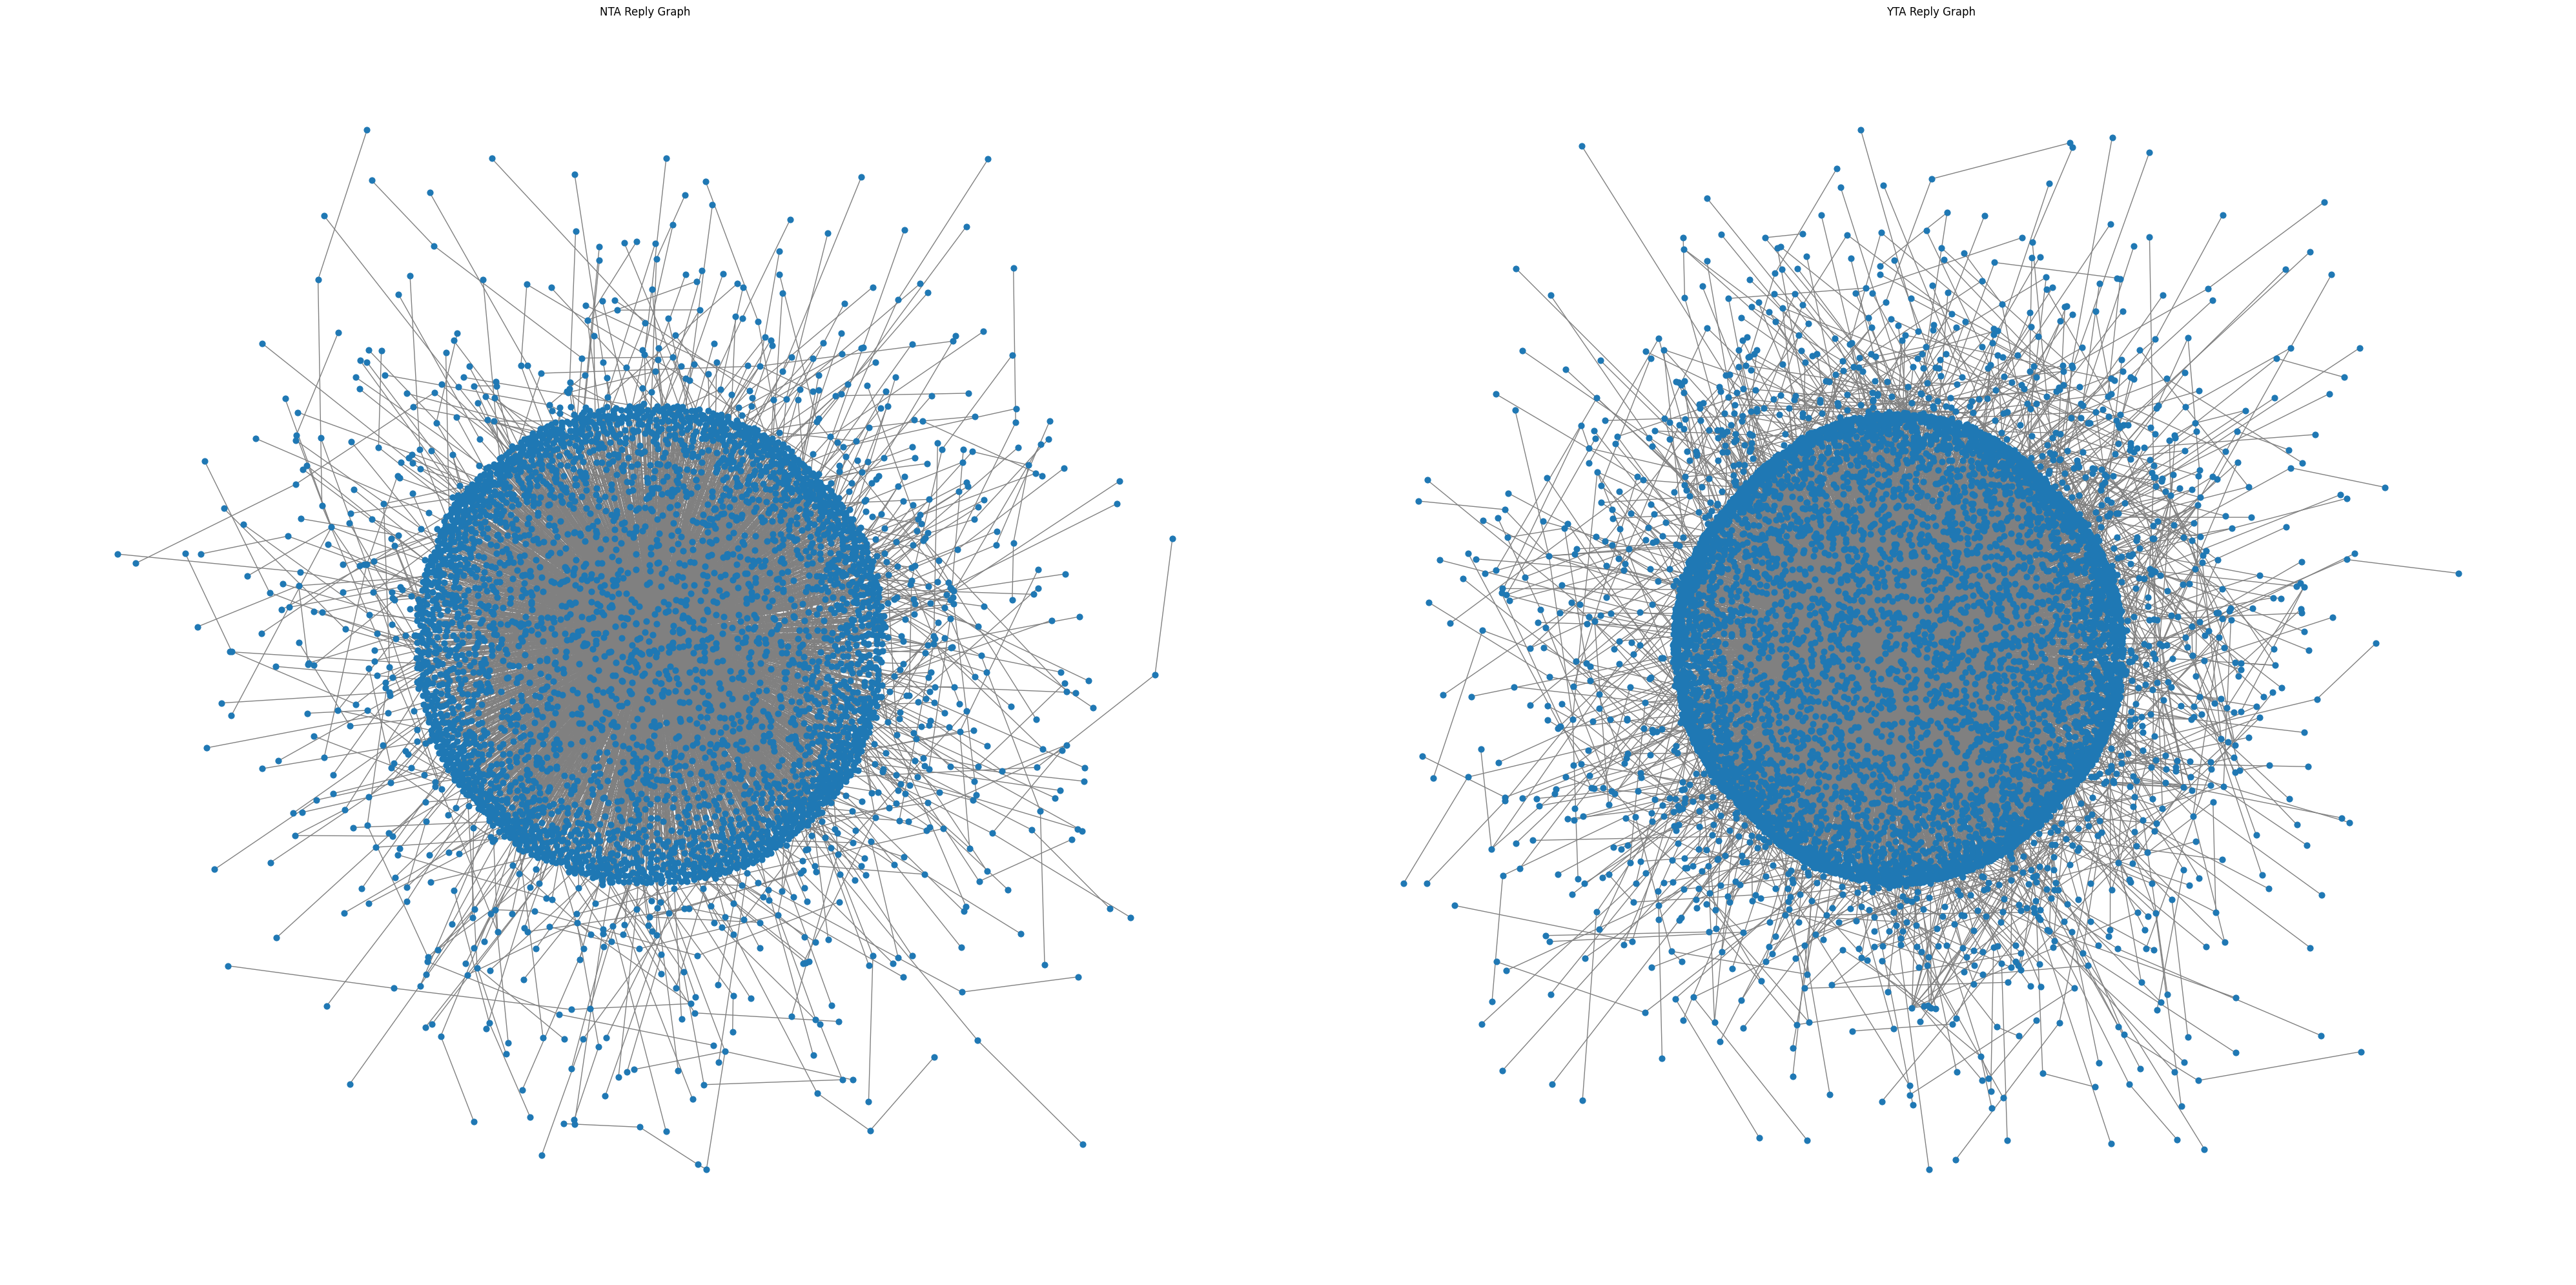

In [10]:
df_NTA = list(rel_NTAHole.values())[3]
df_YTA = list(rel_AHole.values())[5]

# Create two empty graphs
G_NTA = nx.Graph()
G_YTA = nx.Graph()

# Populate the NTA graph
for _, row in df_NTA.iterrows():
    G_NTA.add_edge(row['parent_id'], row['child_id'])

# Populate the YTA graph
for _, row in df_YTA.iterrows():
    G_YTA.add_edge(row['parent_id'], row['child_id'])

# Create a figure with 1×2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

# Draw the NTA graph in the left subplot
nx.draw_spring(
    G_NTA,
    ax=ax1,
    node_size=40,
    with_labels=False,
    edge_color='gray'
)
ax1.set_title("NTA Reply Graph")

# Draw the YTA graph in the right subplot
nx.draw_spring(
    G_YTA,
    ax=ax2,
    node_size=40,
    with_labels=False,
    edge_color='gray'
)
ax2.set_title("YTA Reply Graph")

plt.tight_layout()
plt.show()


## Morphology Analysis

In [11]:
G_NTA_dict = {}
G_YTA_dict = {}

for submission_id, df_edges in rel_NTAHole.items():
    G = nx.DiGraph()
    for _, row in df_edges.iterrows():
        G.add_edge(row['parent_id'], row['child_id'])
    G_NTA_dict[submission_id] = G

for submission_id, df_edges in rel_AHole.items():
    G = nx.DiGraph()
    for _, row in df_edges.iterrows():
        G.add_edge(row['parent_id'], row['child_id'])
    G_YTA_dict[submission_id] = G

### Depth, Branching and Shape Imbalance Analysis

In [56]:
def compute_reply_graph_stats(G_dict):
    """
    For each submission-ID → reply-graph (a directed graph where the submission node is the only root),
    compute:
      - number_of_nodes: total number of nodes in G
      - max_depth:      longest chain of replies from the root
      - avg_depth:      average depth (hops from the root)
      - median_depth:   median of all node depths
      - percent_deeper_3: percentage of nodes with depth > 3
      - percent_deeper_5: percentage of nodes with depth > 5
      - percent_deeper_7: percentage of nodes with depth > 7
      - avg_branching:  average number of replies for any comment that has ≥1 reply (excluding the node with max out-degree)
      - max_branching:  maximum number of direct replies under any single comment (excluding the node with max out-degree)
      - shape_imbalance: S / (n * log2(n)), where S = sum(depth[v] for all leaves v)
    """
    rows = []
    for submission_id, G in G_dict.items():
        # Identify the root: the node with in_degree == 0
        roots = [n for n, d in G.in_degree() if d == 0]
        root = roots[0]
        assert root is not None

        # ___________Depth_Measures________________
        dist = nx.single_source_shortest_path_length(G, root)
        depth_vals = list(dist.values())

        max_depth = max(depth_vals)
        avg_depth = sum(depth_vals) / len(depth_vals)
        median_depth = statistics.median(depth_vals)

        percent_deeper = {}
        for k in (3, 5, 7):
            count_deeper = sum(1 for d in depth_vals if d > k)
            percent_deeper[k] = 100.0 * count_deeper / len(depth_vals)

        # ___________Branching_Measures____________________
        # Collect out-degrees for all nodes that have at least one child
        child_counts = [G.out_degree(n) for n in G.nodes() if G.out_degree(n) > 0]

        # Remove the maximum out-degree once to exclude the single largest branching node
        # (often the root) from the "average branching" calculation
        if child_counts:
            max_val = max(child_counts)
            child_counts.remove(max_val)

        if child_counts:
            avg_branch = sum(child_counts) / len(child_counts)
            max_branch = max(child_counts)
        else:
            avg_branch = 0
            max_branch = 0

        # ___________Shape_Imbalance_____________________
        # Compute shortest-path lengths from root to every node
        depth = nx.single_source_shortest_path_length(G, root)
        # Identify leaves: nodes with out_degree == 0
        leaves = [v for v in G.nodes() if G.out_degree(v) == 0]
        S = sum(depth[v] for v in leaves)
        n = G.number_of_nodes()
        shape_imbalance = S / (n * math.log2(n) if n > 1 else 1)

        rows.append({
            "submission_id": submission_id,
            "number_of_nodes": G.number_of_nodes(),
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "median_depth": median_depth,
            "percent_deeper_3": percent_deeper[3],
            "percent_deeper_5": percent_deeper[5],
            "percent_deeper_7": percent_deeper[7],
            "avg_branching": avg_branch,
            "max_branching": max_branch,
            "shape_imbalance": shape_imbalance
        })

    return pd.DataFrame(rows)

# Example usage:
metrics_NTA = compute_reply_graph_stats(G_NTA_dict)
metrics_YTA = compute_reply_graph_stats(G_YTA_dict)

metrics_NTA.to_csv("metrics_NTA.csv", index=False)
metrics_YTA.to_csv("metrics_YTA.csv", index=False)

In [60]:
metrics_NTA.head()

submission_id  number_of_nodes  max_depth  avg_depth  median_depth  \
0        daglhs             4028         23   3.023337           1.0   
1        wp874j             1750         18   2.532571           1.0   
2        1087lb             7628         15   2.067383           1.0   
3        vnl1hw             4495         25   2.457175           1.0   
4        f3asns             2651         12   1.754055           1.0   

   percent_deeper_3  percent_deeper_5  percent_deeper_7  avg_branching  \
0         30.685204         18.123138          9.210526       2.162383   
1         24.285714         12.171429          5.257143       2.157270   
2         16.413214          8.127950          3.959098       2.423913   
3         22.580645         12.903226          6.295884       2.149740   
4         11.769144          5.394191          2.225575       1.737662   

   max_branching  shape_imbalance  
0             97         0.152616  
1             25         0.164642  
2            113         0.120463  
3             88         0.138313  
4             16         0.113341

In [58]:
metrics_YTA.describe()

number_of_nodes  max_depth  avg_depth  median_depth  percent_deeper_3  \
count        20.000000  20.000000  20.000000     20.000000         20.000000   
mean       4889.050000  22.500000   2.972549      1.750000         28.446559   
std        2560.987525   8.708737   1.004566      0.966546         13.108983   
min         693.000000  11.000000   1.688018      1.000000         10.667316   
25%        2920.250000  15.250000   2.266233      1.000000         19.500997   
50%        4665.500000  23.000000   2.466782      1.000000         22.221525   
75%        6212.500000  29.250000   3.798969      2.250000         38.704393   
max        9724.000000  37.000000   5.217288      4.000000         55.091770   

       percent_deeper_5  percent_deeper_7  avg_branching  max_branching  \
count         20.000000         20.000000      20.000000      20.000000   
mean          16.538660          9.102304       2.054764      82.350000   
std            9.954054          6.999354       0.263327      32.653323   
min            4.724793          1.242085       1.735736      24.000000   
25%            9.689427          3.989727       1.873484      64.000000   
50%           11.856644          5.796627       1.997514      88.500000   
75%           24.584381         14.861386       2.164021     100.750000   
max           37.951451         23.741859       2.655118     145.000000   

       shape_imbalance  
count        20.000000  
mean          0.147204  
std           0.028703  
min           0.109470  
25%           0.124860  
50%           0.143558  
75%           0.161655  
max           0.201081

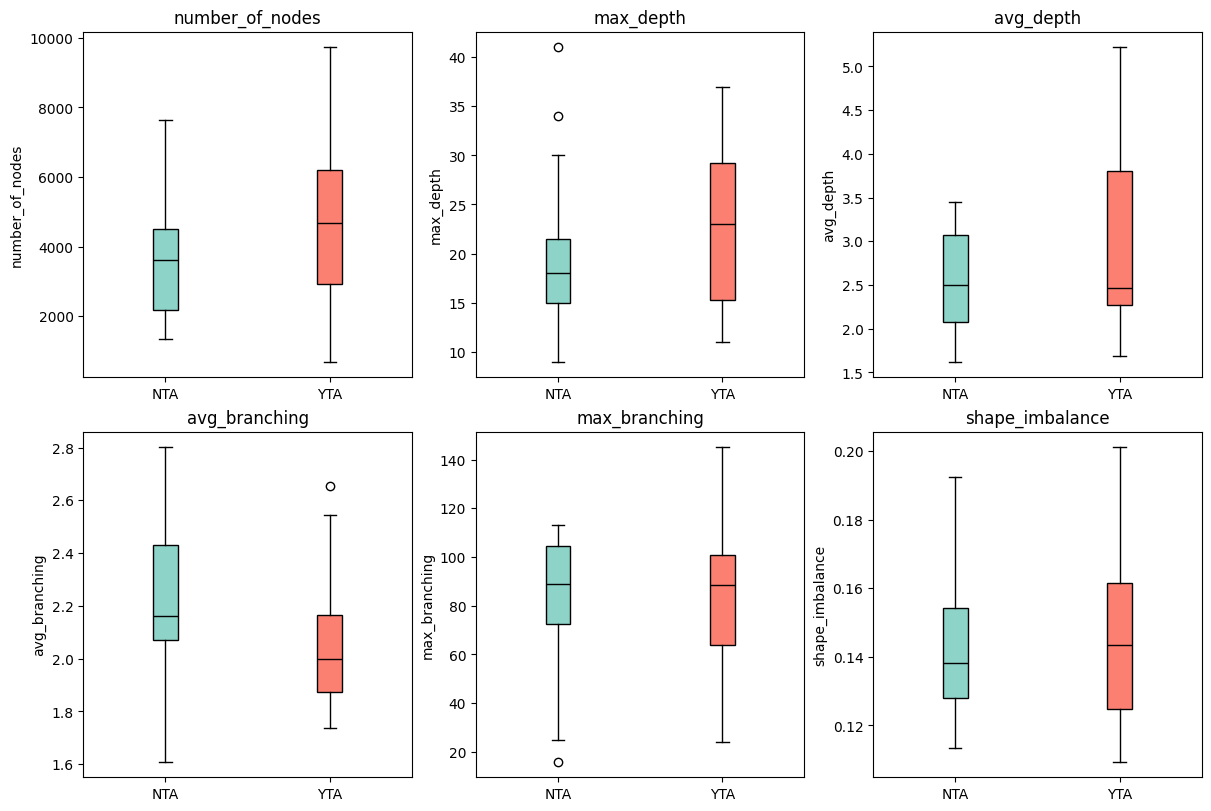

In [67]:
import matplotlib.pyplot as plt

metrics_list = [
    'number_of_nodes',
    'max_depth',
    'avg_depth',
    'avg_branching',
    'max_branching',
    'shape_imbalance'
]

# Create a 2×3 grid of subplots with a smaller figure size
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 8),
    constrained_layout=True
)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Choose two distinct, pleasant colors for NTA and YTA
colors = ['#8dd3c7', '#fb8072']  # soft green and soft salmon

for ax, metric in zip(axes, metrics_list):
    # Extract values (no NaNs to drop)
    nta_vals = metrics_NTA[metric].values
    yta_vals = metrics_YTA[metric].values

    data = [nta_vals, yta_vals]

    # Draw the boxplot with patch_artist=True so we can set individual box colors
    bp = ax.boxplot(
        data,
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markeredgecolor='black')
    )

    # Apply colors to each box
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Use tick_labels instead of the 'labels' parameter
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['NTA', 'YTA'])

    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.show()


### OP presence analysis

Higher Rᵒᵖ or ρᵒᵖ in YTA? → OP argues back more when being judged “the asshole.”

Lower d̄ᵒᵖ in NTA? → OP’s replies stay near the surface (quick clarifications) when absolved.

In [61]:
def compute_op_presence(graph_dict):
    """
    Returns for each submission:
      op_reply_count   : number of OP replies
      op_reply_ratio   : OP replies / total comments
      op_average_depth : mean depth of OP replies
    """
    rows = []

    for sid, edges in graph_dict.items():
        G = nx.DiGraph()

        #________build_graph________
        for _, r in edges.iterrows():
            G.add_edge(r.parent_id, r.child_id)
            if pd.notna(r.parent_author):
                G.nodes[r.parent_id]["author"] = r.parent_author
            if pd.notna(r.child_author):
                G.nodes[r.child_id]["author"] = r.child_author

        #________identify_root_op________
        root = next(n for n in G if G.in_degree(n) == 0)
        op_author = G.nodes[root].get("author")

        #________collect_op_nodes________
        op_nodes = [n for n in G if n != root and G.nodes[n].get("author") == op_author]
        op_reply_count = len(op_nodes)
        op_reply_ratio = op_reply_count / (G.number_of_nodes() - 1) if G.number_of_nodes() > 1 else 0

        #________compute_depth________
        depths = nx.shortest_path_length(G, root)
        op_average_depth = np.mean([depths[n] for n in op_nodes]) if op_reply_count else np.nan

        rows.append({
            "submission_id": sid,
            "op_reply_count": op_reply_count,
            "op_reply_ratio": op_reply_ratio,
            "op_average_depth": op_average_depth
        })

    return pd.DataFrame(rows)

op_metrics_NTA = compute_op_presence(rel_NTAHole)
op_metrics_YTA = compute_op_presence(rel_AHole)
op_metrics_NTA.to_csv("op_presence_NTA.csv", index=False)
op_metrics_YTA.to_csv("op_presence_YTA.csv", index=False)


In [77]:
print(f"Number of submission without OP replies:\nNTA: {sum(op_metrics_NTA["op_reply_count"] == 0)}\nYTA: {sum(op_metrics_YTA["op_reply_count"] == 0)}")

Number of submission without OP replies:
NTA: 2
YTA: 9


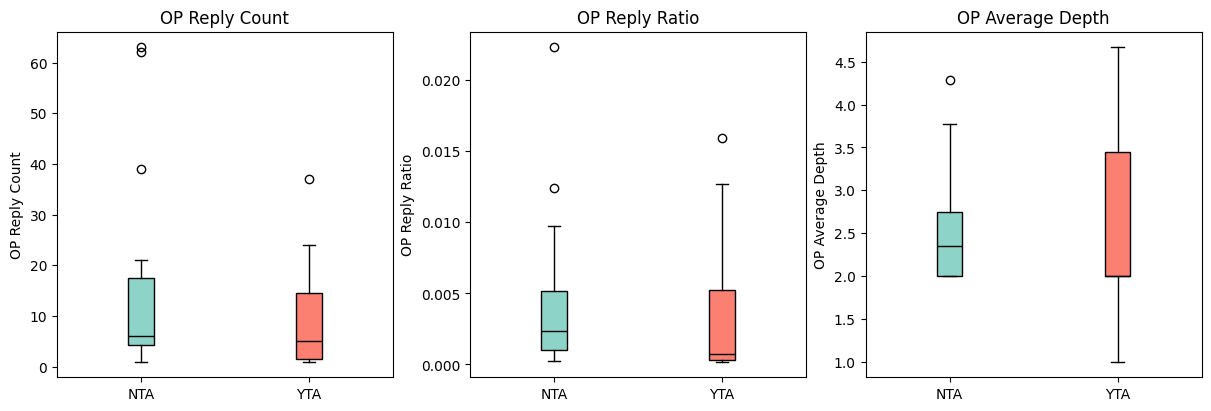

In [78]:
filtered_NTA = op_metrics_NTA[op_metrics_NTA.op_reply_count > 0]
filtered_YTA = op_metrics_YTA[op_metrics_YTA.op_reply_count > 0]

metrics = [
    ("op_reply_count",  "OP Reply Count"),
    ("op_reply_ratio",  "OP Reply Ratio"),
    ("op_average_depth","OP Average Depth")
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True
)

# pleasant NTA / YTA colours
colors = ['#8dd3c7', '#fb8072']

for ax, (col, title) in zip(axes, metrics):
    data = [
        filtered_NTA[col].values,
        filtered_YTA[col].values
    ]
    bp = ax.boxplot(
        data,
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markeredgecolor='black')
    )
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
        patch.set_edgecolor('black')

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['NTA', 'YTA'])
    ax.set_title(title)
    ax.set_ylabel(title)

plt.show()


# User-Interaction Graph Analysis

## Fetching User Interaction Graph

In [4]:
df = pd.read_csv("top450-aita-balanced.csv")

In [ ]:
def extractFromCommentAITA(c):
    author = str(c.author) if c.author is not None else None
    reply_id = c.id
    score = c.score
    text = c.body
    if "YTA" in text:
        vote = "YTA"
    elif "NTA" in text:
        vote = "NTA"
    else:
        vote = None

    return author, reply_id, score, vote
    

edges = []

for id in tqdm(df.id, desc="Iteration"):
    sub = reddit.submission(id)
    sub.comments.replace_more(limit=5)
    for comment_1 in sub.comments:
        p_author, _, p_score, p_vote = extractFromCommentAITA(comment_1)
        # submission author ignored
        for comment_2 in comment_1.replies:
            c1_author, _, c1_score, c1_vote = extractFromCommentAITA(comment_2)
            edges.append((p_author,c1_author,p_vote,c1_vote,p_score,c1_score))
            for comment_3 in comment_2.replies:
                c2_author, _, c2_score, c2_vote = extractFromCommentAITA(comment_3)
                edges.append((c1_author,c2_author,c1_vote,c2_vote,c1_score,c2_score))

if edges:
    df = pd.DataFrame(
        edges,
        columns=['parent_author', 'child_author', 'parent_vote', 'child_vote', "parent_score", "child_score"]
    )
    # df.to_csv(f"User-Interaction_graph.csv", index=False)

Iteration: 100%|██████████| 450/450 [58:50<00:00,  7.85s/it] 


## Visualizing authors properties

In [27]:
authors_rel_df = pd.read_csv("User-Interaction_graph.csv")
authors_rel_df

parent_author          child_author parent_vote child_vote  \
0      Angrychristmassgnome  Angrychristmassgnome         YTA        NaN   
1      Angrychristmassgnome          danger_o_day         NaN        NaN   
2      Angrychristmassgnome                akamj7         NaN        NaN   
3      Angrychristmassgnome   AnimatronicAardvark         YTA        NaN   
4       AnimatronicAardvark  Angrychristmassgnome         NaN        NaN   
...                     ...                   ...         ...        ...   
85077                   NaN          True_Falsity         YTA        NaN   
85078                   NaN              lt_girth         YTA        NaN   
85079                   NaN                   NaN         YTA        NaN   
85080            ajkeence99          True_Falsity         YTA        NaN   
85081          True_Falsity            ajkeence99         NaN        NaN   

       parent_score  child_score  
0              2035          501  
1               501          264  
2               501           14  
3              2035          166  
4               166           11  
...             ...          ...  
85077           -80           17  
85078           -80            6  
85079           -80            2  
85080           -20           13  
85081            13          -12  

[85082 rows x 6 columns]

In [28]:
authors_df = pd.concat(
    [
        authors_rel_df[['child_author', 'child_vote', 'child_score']]
            .rename(columns={
                'child_author': 'author',
                'child_vote':  'vote',
                'child_score': 'score'
            }),
        
        authors_rel_df[['parent_author', 'parent_vote', 'parent_score']]
            .rename(columns={
                'parent_author': 'author',
                'parent_vote':  'vote',
                'parent_score': 'score'
            })
    ],
    ignore_index=True
)

vote_map = {'YTA':  1, 'NTA': -1}
authors_df['YTA-NTA_count'] = authors_df['vote'].map(vote_map)

authors_df = (
    authors_df
      .groupby('author')
      .agg(
        YTA_NTA_count  = ('YTA-NTA_count', 'sum'),
        score_sum = ('score',    'sum')
      )
      .reset_index()
)

authors_df

author  YTA_NTA_count  score_sum
0            ---jordan---            0.0        207
1                 --BMO--           -1.0        619
2                --Julius            0.0         -6
3      --pobodysnerfect--            2.0       3190
4         --whatthefuck--            0.0         18
...                   ...            ...        ...
55311             zykthyr            0.0         33
55312              zzTopo            0.0          6
55313         zzaannsebar            0.0       3623
55314        zzzombieface           -3.0          3
55315            zzzzbear            0.0         53

[55316 rows x 3 columns]

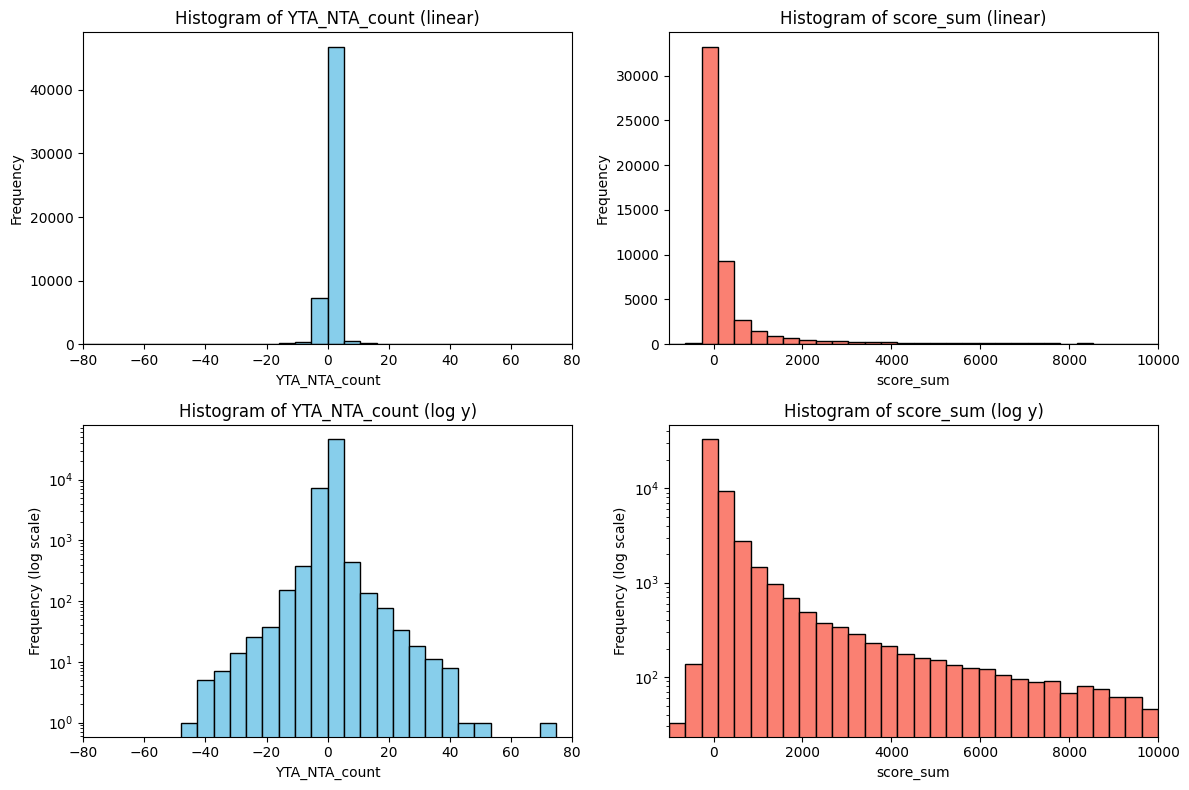

In [6]:
x1_min, x1_max = -80, 80
x2_min, x2_max = -1000, 10000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), tight_layout=True)

axes[0, 0].hist(
    authors_df['YTA_NTA_count'].dropna(),
    bins=30,
    range=(x1_min, x1_max),
    color='skyblue',
    edgecolor='black'
)
axes[0, 0].set_title('Histogram of YTA_NTA_count (linear)')
axes[0, 0].set_xlabel('YTA_NTA_count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(x1_min, x1_max)

axes[0, 1].hist(
    authors_df['score_sum'].dropna(),
    bins=30,
    range=(x2_min, x2_max),
    color='salmon',
    edgecolor='black'
)
axes[0, 1].set_title('Histogram of score_sum (linear)')
axes[0, 1].set_xlabel('score_sum')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(x2_min, x2_max)

axes[1, 0].hist(
    authors_df['YTA_NTA_count'].dropna(),
    bins=30,
    range=(x1_min, x1_max),
    color='skyblue',
    edgecolor='black',
    log=True
)
axes[1, 0].set_title('Histogram of YTA_NTA_count (log y)')
axes[1, 0].set_xlabel('YTA_NTA_count')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_xlim(x1_min, x1_max)

axes[1, 1].hist(
    authors_df['score_sum'].dropna(),
    bins=30,
    range=(x2_min, x2_max),
    color='salmon',
    edgecolor='black',
    log=True
)
axes[1, 1].set_title('Histogram of score_sum (log y)')
axes[1, 1].set_xlabel('score_sum')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_xlim(x2_min, x2_max)

plt.show()


## Constructing the final graph

In [7]:
edges_df = (
    authors_rel_df
    .groupby(['parent_author', 'child_author'])
    .size()
    .reset_index(name='weight')
    .rename(columns={'parent_author': 'parent', 'child_author': 'child'})
)
print(edges_df["weight"].value_counts())
edges_df.head()

weight
1    60408
2      213
3       25
4        2
Name: count, dtype: int64


parent                 child  weight
0             --BMO--             italy2986       1
1            --Julius          OakTreeTrash       1
2  --pobodysnerfect--           spankcheeks       1
3     -Artful_Dodger-  Individual_Umpire969       1
4     -Artful_Dodger-     Pure-Fishing-3350       1

In [8]:
G = nx.DiGraph()

for _, row in authors_df.iterrows():
    G.add_node(row['author'], YTA_NTA_count=row['YTA_NTA_count'], score=row['score_sum'])

for _, row in edges_df.iterrows():
    G.add_edge(row['parent'], row['child'], weight=row['weight'])


## Graph Visualization

### Visualizing Graph (color = YTA-NTA count)

In [9]:
# colors range for yta-nta
count_vmin = -20
count_vmax = 20 

# colors range for score
score_vmin=-3000
score_vmax= 5000

11167
10319


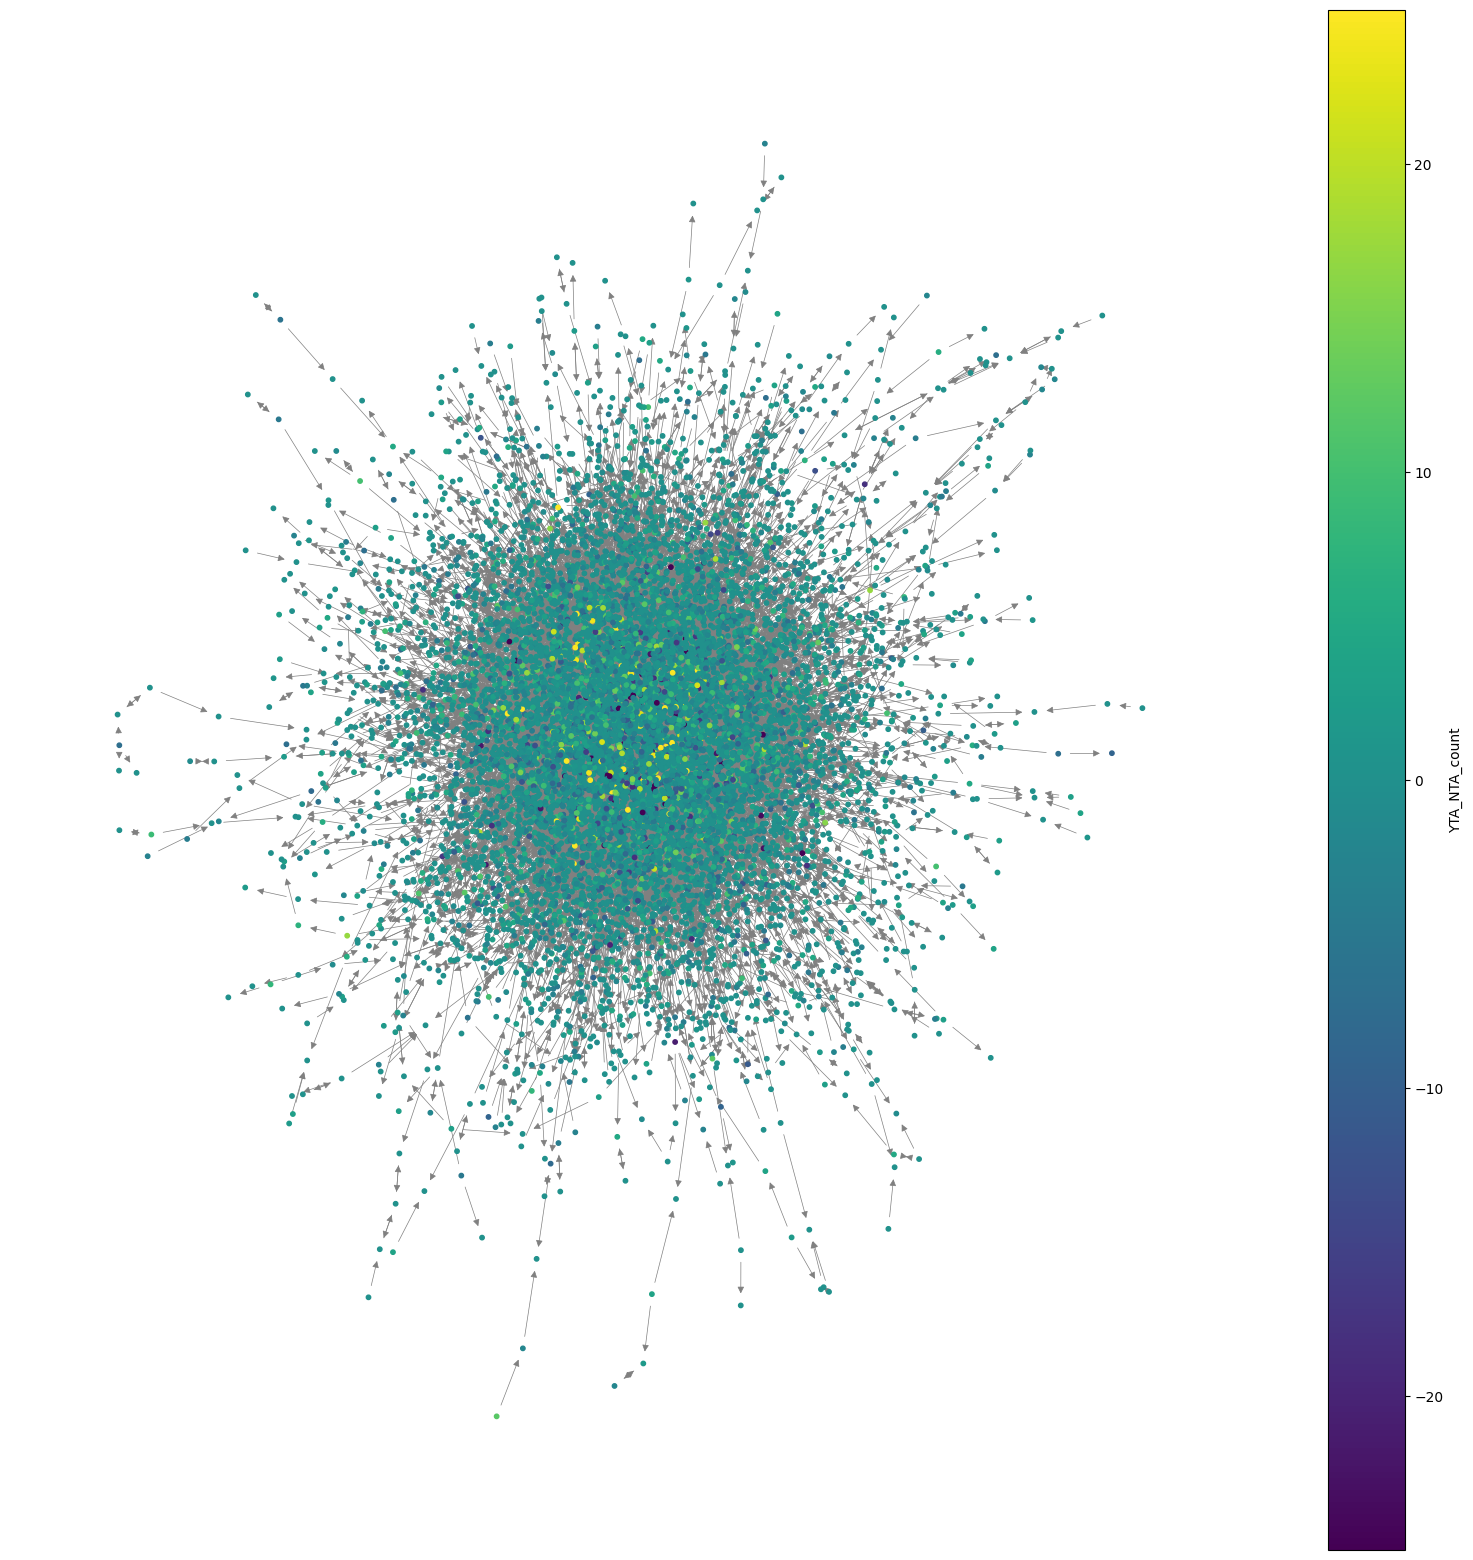

In [ ]:
degree_threshold = 2
subset_nodes = [n for n in G.nodes() if G.degree(n) > degree_threshold]
print(len(subset_nodes))

H = G.subgraph(subset_nodes).copy()
H.remove_edges_from(nx.selfloop_edges(H))
largest_cc_nodes = max(nx.weakly_connected_components(H), key=len)
H = H.subgraph(largest_cc_nodes).copy()
print(H.number_of_nodes())

pos = nx.spring_layout(H)
fig, ax = plt.subplots(figsize=(20, 20))
values = [H.nodes[n]['YTA_NTA_count'] for n in H.nodes()]
norm = mcolors.Normalize(vmin=count_vmin, vmax=count_vmax)
cmap = cm.viridis
node_colors = [cmap(norm(H.nodes[n]['YTA_NTA_count'])) for n in H.nodes()]

edge_weights = [H[u][v]['weight'] for u, v in H.edges()]
min_w, max_w = min(edge_weights), max(edge_weights)
edge_widths = [((w - min_w) / (max_w - min_w) * 4) + 0.5 for w in edge_weights]

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=10, ax=ax)
nx.draw_networkx_edges(H, pos, arrows=True, width=edge_widths, edge_color="gray", ax=ax)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='YTA_NTA_count')

ax.axis('off')
plt.show()


### Visualizing Graph (color = score sum)

11167
10319


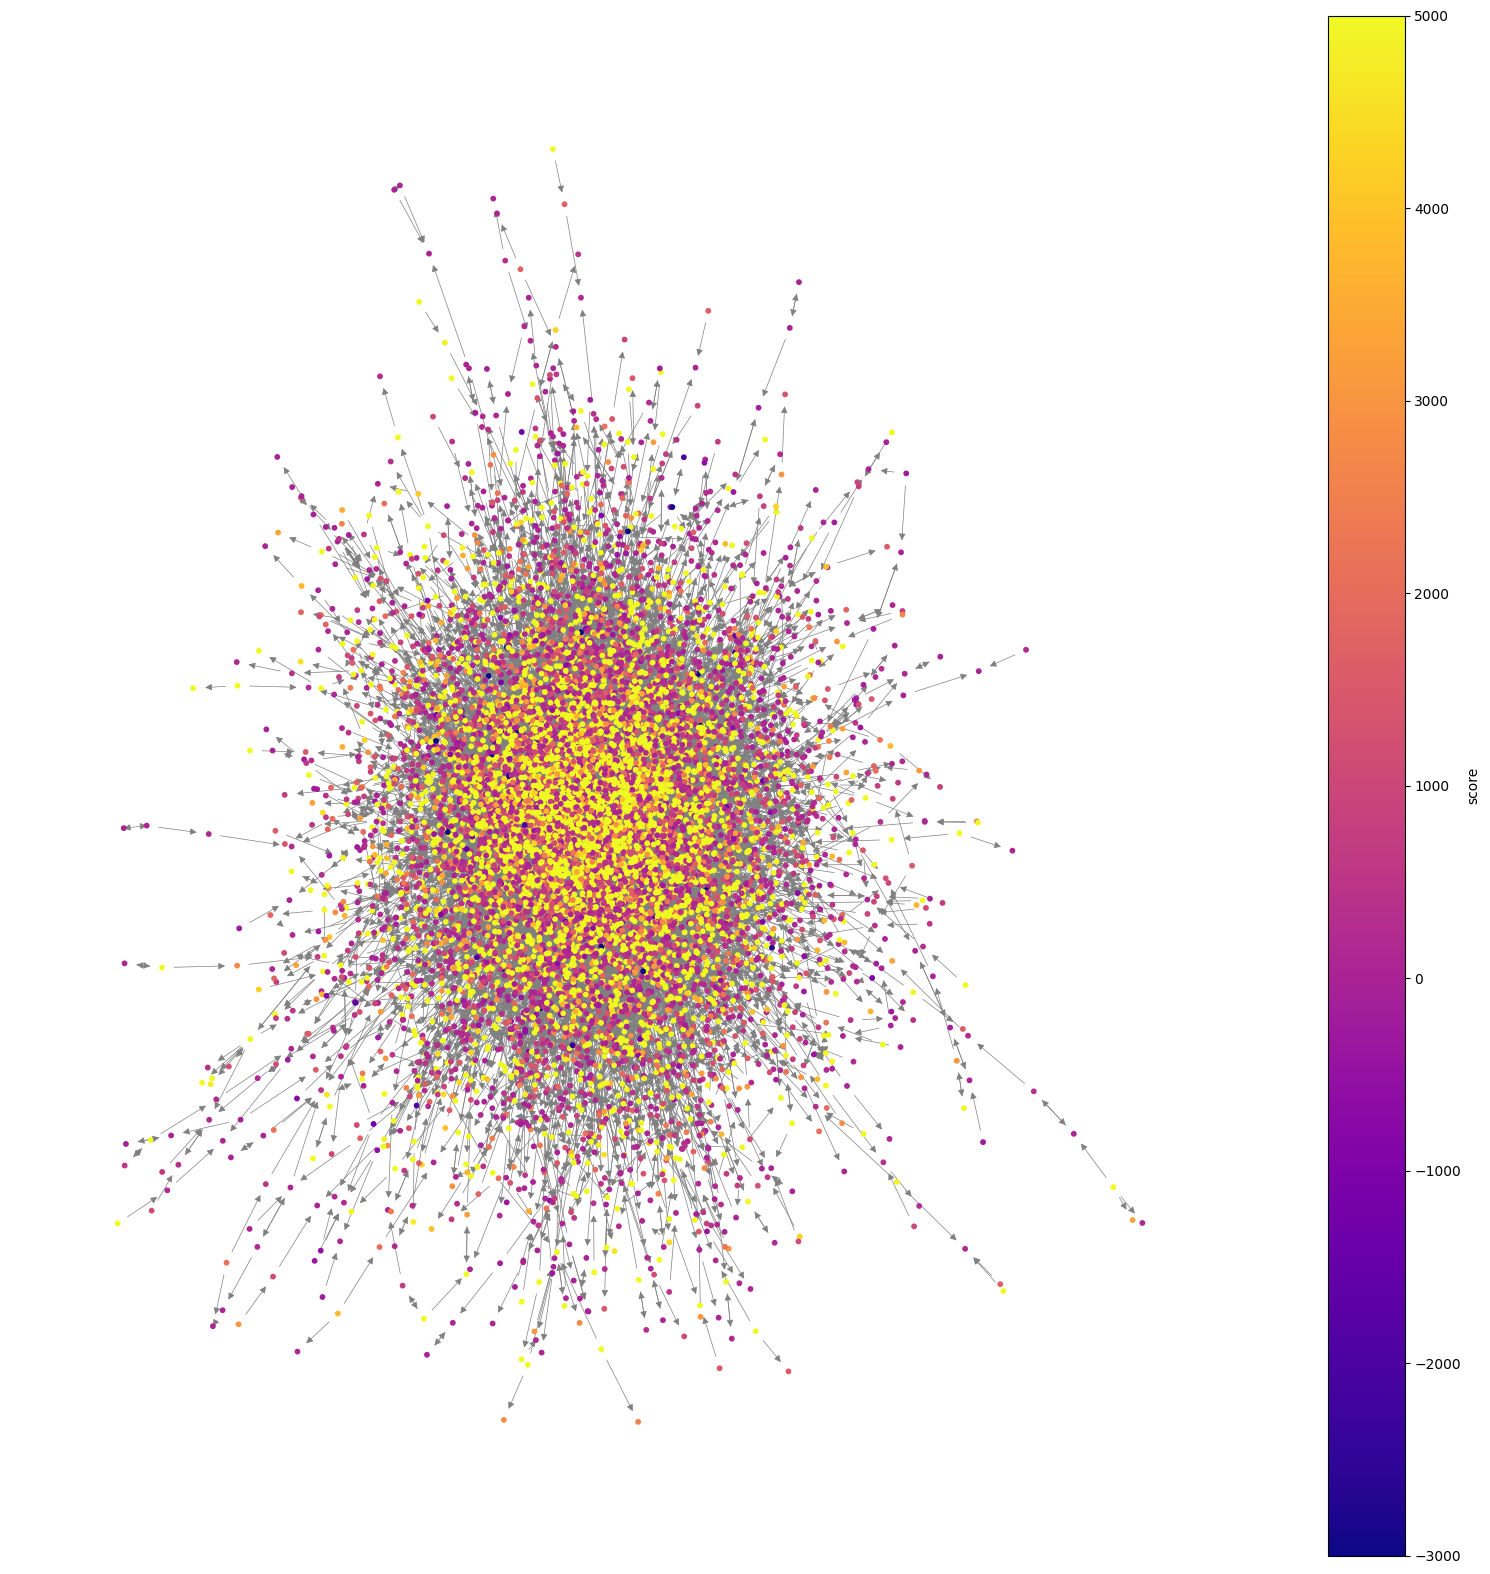

In [24]:
degree_threshold = 2

subset_nodes = [n for n in G.nodes() if G.degree(n) > degree_threshold]
print(len(subset_nodes))

H = G.subgraph(subset_nodes).copy()
H.remove_edges_from(nx.selfloop_edges(H))
largest_cc_nodes = max(nx.weakly_connected_components(H), key=len)
H = H.subgraph(largest_cc_nodes).copy()
print(H.number_of_nodes())

pos = nx.spring_layout(H)
fig, ax = plt.subplots(figsize=(20, 20))
values = [H.nodes[n]['score'] for n in H.nodes()]
norm = mcolors.Normalize(vmin=score_vmin, vmax=score_vmax)
cmap = cm.plasma
node_colors = [cmap(norm(H.nodes[n]['score'])) for n in H.nodes()]

edge_weights = [H[u][v]['weight'] for u, v in H.edges()]
min_w, max_w = min(edge_weights), max(edge_weights)
edge_widths = [((w - min_w) / (max_w - min_w) * 4) + 0.5 for w in edge_weights]

nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=10, ax=ax)
nx.draw_networkx_edges(H, pos, arrows=True, width=edge_widths, edge_color="gray", ax=ax)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='score')

ax.axis('off')
plt.show()


## In vs Out Degree Distribution

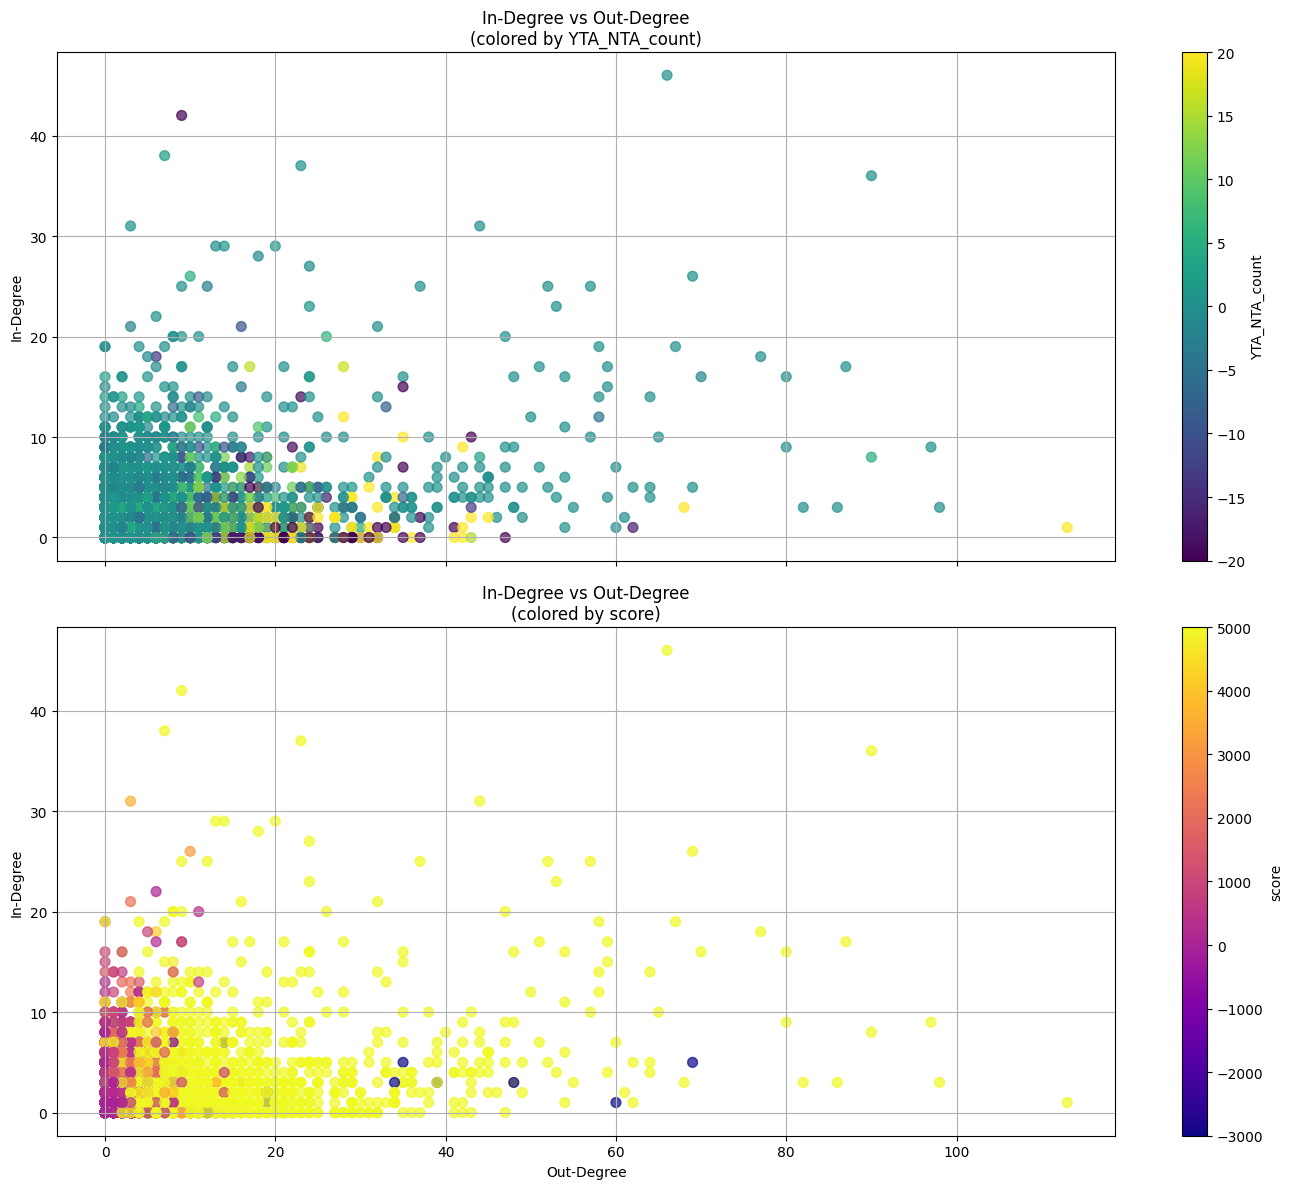

In [23]:
nodes = list(G.nodes())
in_degrees = [G.in_degree(n) for n in nodes]
out_degrees = [G.out_degree(n) for n in nodes]

norm_yt = mcolors.Normalize(vmin=count_vmin, vmax=count_vmax)
cmap_yt = cm.viridis
yt_counts = [G.nodes[n]['YTA_NTA_count'] for n in nodes]
node_colors_yt = [cmap_yt(norm_yt(val)) for val in yt_counts]


scores = [G.nodes[n]['score'] for n in nodes]

norm_sc = mcolors.Normalize(vmin=score_vmin, vmax=score_vmax)
cmap_sc = cm.plasma
node_colors_sc = [cmap_sc(norm_sc(val)) for val in scores]

# Create figure with two stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)


sc1 = ax1.scatter(out_degrees, in_degrees, c=node_colors_yt, alpha=0.7, s=50)
ax1.set_ylabel('In-Degree')
ax1.set_title('In-Degree vs Out-Degree\n(colored by YTA_NTA_count)')
ax1.grid(True)
cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm_yt, cmap=cmap_yt), ax=ax1)
cbar1.set_label('YTA_NTA_count')

sc2 = ax2.scatter(out_degrees, in_degrees, c=node_colors_sc, alpha=0.7, s=50)
ax2.set_xlabel('Out-Degree')
ax2.set_ylabel('In-Degree')
ax2.set_title('In-Degree vs Out-Degree\n(colored by score)')
ax2.grid(True)
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm_sc, cmap=cmap_sc), ax=ax2)
cbar2.set_label('score')

plt.tight_layout()
plt.show()


## Assortativity and Clustering Coefficient

In [10]:
edges = list(G.edges())
k = int(len(edges) * 0.4) # kernel crashes with higher values
sampled = random.sample(edges, k)
G_sub = G.edge_subgraph(sampled).copy()

score_assortativity = assortativity.numeric_assortativity_coefficient(G_sub, 'score')
YTA_NTA_count_assortativity = assortativity.numeric_assortativity_coefficient(G_sub, 'YTA_NTA_count')
degree_assortativity = nx.degree_assortativity_coefficient(G)
clustering_coefficient = nx.average_clustering(G)

metrics = {
    'Score assortativity': score_assortativity,
    'YTA/NTA count assortativity': YTA_NTA_count_assortativity,
    'Degree assortativity': degree_assortativity,
    'Average Clustering Coefficient': clustering_coefficient
}

for name, value in metrics.items():
    print(f"{name:30}: {value:.4f}")

Score assortativity           : -0.0068
YTA/NTA count assortativity   : 0.0698
Degree assortativity          : -0.0515
Average Clustering Coefficient: 0.0021


## Centrality Measures

In [ ]:
giant = max(nx.weakly_connected_components(G), key=len)
giant_component_graph = G.subgraph(giant)

cl_cen = nx.closeness_centrality(giant_component_graph)
bt_cen = nx.betweenness_centrality(
    giant_component_graph, k=5000,
    normalized=True,
    endpoints=False
)
dg_cen = nx.degree_centrality(giant_component_graph)

In [37]:
metrics = {
    'closeness_centrality': cl_cen,
    'betweenness_centrality': bt_cen,
    'degree_centrality': dg_cen
}

for colname, metric_dict in metrics.items():
    authors_df[colname] = (
        authors_df['author']
          .map(pd.Series(metric_dict))
    )
    
authors_df.to_csv("user_interaction_graph-centrality_metrics.csv", index=False)
authors_df.head()

author  YTA_NTA_count  score_sum  closeness_centrality  \
0        ---jordan---            0.0        207              0.007494   
1             --BMO--           -1.0        619              0.000000   
2            --Julius            0.0         -6              0.009327   
3  --pobodysnerfect--            2.0       3190              0.000000   
4     --whatthefuck--            0.0         18              0.000154   

   betweenness_centrality  degree_centrality  
0                     0.0           0.000024  
1                     0.0           0.000024  
2                     0.0           0.000047  
3                     0.0           0.000024  
4                     0.0           0.000024

In [38]:
authors_df = pd.read_csv("user_interaction_graph-centrality_metrics.csv")
authors_df.describe()

YTA_NTA_count     score_sum  closeness_centrality  \
count   55316.000000  5.531600e+04          42198.000000   
mean        0.016162  9.383994e+03              0.002793   
std         2.338442  8.528279e+04              0.003729   
min       -46.000000 -2.809070e+05              0.000000   
25%         0.000000  1.000000e+01              0.000024   
50%         0.000000  4.400000e+01              0.000054   
75%         0.000000  3.650000e+02              0.006964   
max        95.000000  4.608606e+06              0.013277   

       betweenness_centrality  degree_centrality  
count            42198.000000       42198.000000  
mean                 0.000016           0.000063  
std                  0.000157           0.000109  
min                  0.000000           0.000024  
25%                  0.000000           0.000024  
50%                  0.000000           0.000024  
75%                  0.000000           0.000071  
max                  0.007377           0.002986

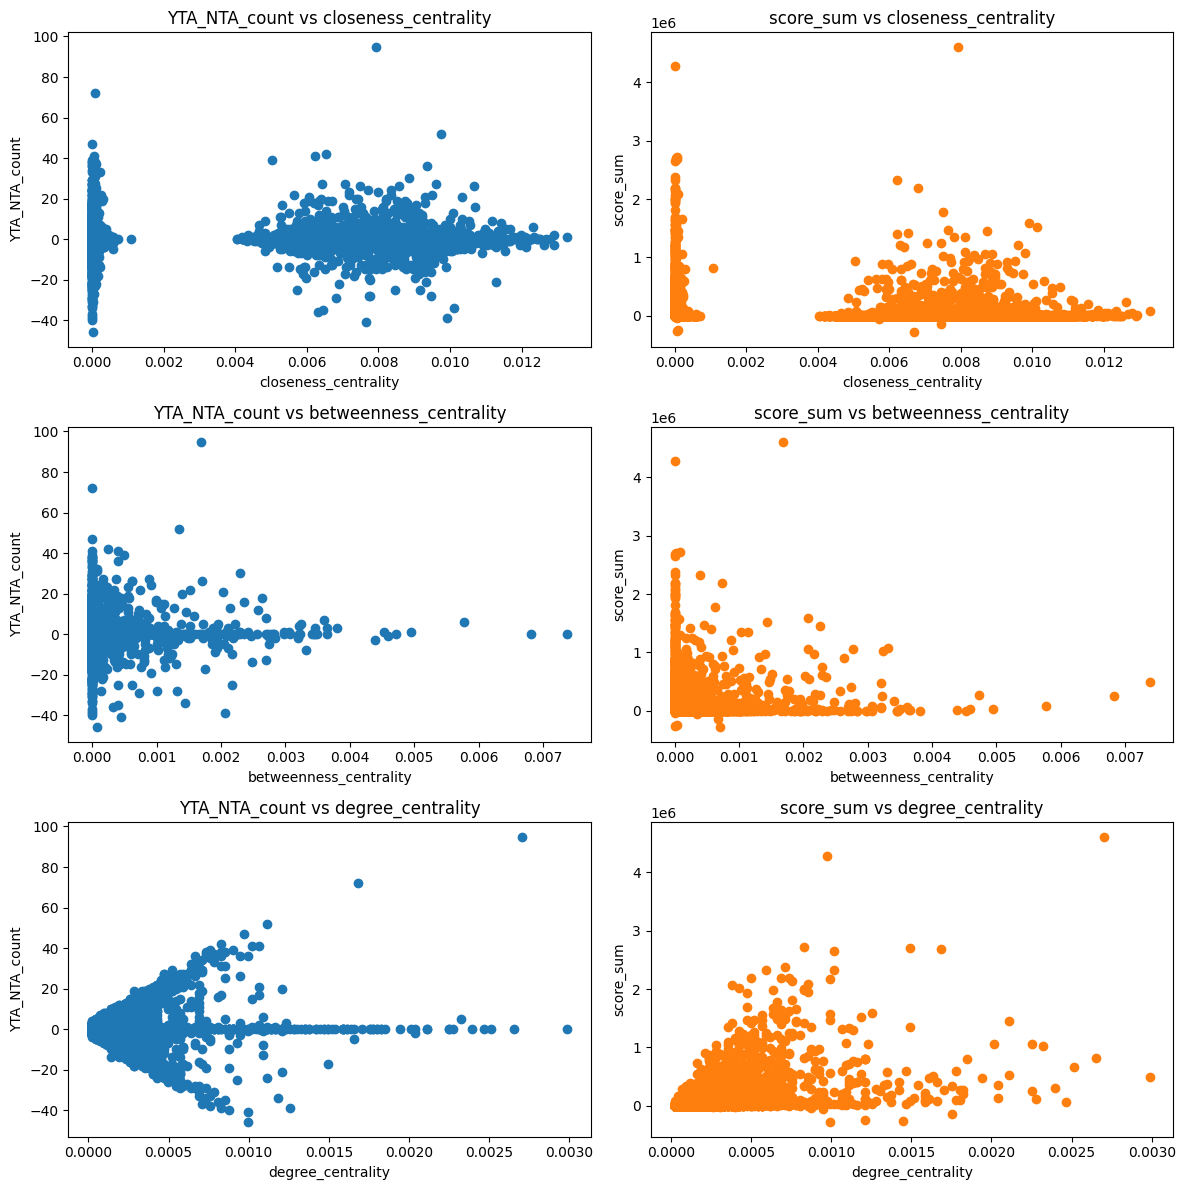

In [39]:
import matplotlib.pyplot as plt

centrality_cols = [
    "closeness_centrality",
    "betweenness_centrality",
    "degree_centrality",
]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, metric in enumerate(centrality_cols):
    axes[i, 0].scatter(authors_df[metric], authors_df["YTA_NTA_count"], color="tab:blue")
    axes[i, 0].set_xlabel(metric)
    axes[i, 0].set_ylabel("YTA_NTA_count")
    axes[i, 0].set_title(f"YTA_NTA_count vs {metric}")

    axes[i, 1].scatter(authors_df[metric], authors_df["score_sum"], color="tab:orange")
    axes[i, 1].set_xlabel(metric)
    axes[i, 1].set_ylabel("score_sum")
    axes[i, 1].set_title(f"score_sum vs {metric}")

plt.tight_layout()
plt.show()
